In [1]:
import pandas as pd

In [7]:
# load every dataset in the db folder and merge them into one
import os

DATA_DIR = '../../db'

db = pd.DataFrame()
dataset_label = pd.Series()
for filename in os.listdir(DATA_DIR):
    if not filename.endswith('.parquet'):
        continue

    # read csv
    df = pd.read_parquet(os.path.join(DATA_DIR, filename))

    # append to dfs
    db = pd.concat([db, df])
    tmp = pd.Series([filename[:-8]] * len(df), index=df.index, name='dataset')
    dataset_label = pd.concat([dataset_label, tmp])

# concat dfs
db = db

In [5]:
import umap
import numpy as np
import matplotlib.pyplot as plt

# Create UMAP embedding
umap_embedding = umap.UMAP().fit_transform(db.dropna(axis=1))

# Plot UMAP embedding
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=pd.Categorical(dataset_label).codes, cmap='Spectral', s=5)
plt.title('UMAP Plot')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(boundaries=np.arange(13)-0.5).set_ticks(np.arange(12))
plt.show()

ValueError: at least one array or dtype is required

In [ ]:
from combat.pycombat import pycombat

batch = pd.Categorical(dataset_label).codes

data_corrected = pycombat(db.transpose(), batch).transpose()

Found 12 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


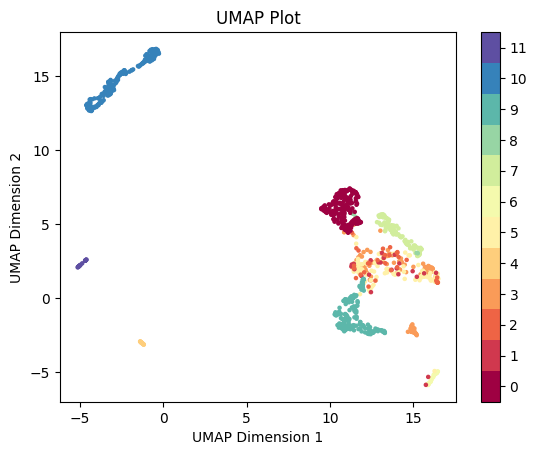

In [ ]:
import umap
import numpy as np
import matplotlib.pyplot as plt

# Create UMAP embedding
umap_embedding = umap.UMAP().fit_transform(data_corrected.dropna(axis=1))

# Plot UMAP embedding
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=pd.Categorical(dataset_label).codes, cmap='Spectral', s=5)
plt.title('UMAP Plot')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(boundaries=np.arange(13)-0.5).set_ticks(np.arange(12))
plt.show()

In [ ]:
selected_sample_idxs = [d in ['GSE23597', 'GSE16879', 'GSE52746', 'GSE14580'] for d in dataset_label]
plot_data = db[selected_sample_idxs]

plt.scatter(plot_data.iloc[:, 6], plot_data.iloc[:, 5], c=pd.Categorical(dataset_label[selected_sample_idxs]).codes, cmap='Spectral', s=5)
plt.show()

NameError: name 'plt' is not defined

In [11]:
db[[d in ['GSE52746'] for d in dataset_label]]

ENTREZ_ID,1,10,100,1000,10000,100008586,100009676,10001,10002,10003,...,92379,92454,934,93949,94057,9503,9593,9598,985,9981
index,,,,,,,,,,,,,,,,,,,,,
GSM1275185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1275186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1275187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1275188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1275189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1275190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1275191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1275192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1275193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
